# **\[SOLAR\]** GConvLSTM +++++++ 이거!!! ++++++++++++

JiyunLim  
2023-08-14

# 2023.08.14 러너 수정

> **변경사항** : 각 시간 스냅샷 후 loss가 역전파되고 가중치가 업데이트
> $\to$ 에폭 당 한번 업데이트

## Import

In [1]:
# modules 
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import torch
import eptstgcn
import eptstgcn.planner
import torch_geometric_temporal
from torch_geometric_temporal.signal.static_graph_temporal_signal import StaticGraphTemporalSignal
import mplcyberpunk

# torch
import torch
import torch.nn.functional as F
#import torch_geometric_temporal
from torch_geometric_temporal.nn.recurrent import GConvLSTM
# from torch_geometric_temporal.nn.recurrent import GCLSTM
# from torch_geometric_temporal.nn.recurrent import LRGCN
# from torch_geometric_temporal.nn.recurrent import TGCN
# from torch_geometric_temporal.nn.recurrent import DCRNN

# read data
def makedict(FX,W=None,node_ids=None):
    T,N = np.array(FX).shape
    if W==None:
        W = pd.DataFrame(FX).corr().to_numpy().reshape(-1).tolist() # corr 로 weights
    if node_ids==None:
        node_ids = ['node'+str(n) for n in range(N)]
    _dict={
        'edges':[[i,j] for i in range(N) for j in range(N)], 
        'node_ids': node_ids,
        'weights':W,
        'FX':FX
    }
    return _dict

class Loader(object):
    def __init__(self, data_dict):
        self._dataset = data_dict
    
    def _get_edges(self):
        self._edges = np.array(self._dataset["edges"]).T

    def _get_edge_weights(self):
        # self._edge_weights = np.array(self._dataset["weights"]).T
        edge_weights = np.array(self._dataset["weights"]).T
        #scaled_edge_weights = minmaxscaler(edge_weights)
        self._edge_weights = edge_weights

    def _get_targets_and_features(self):
        stacked_target = np.stack(self._dataset["FX"])
        self.features = np.stack([
            stacked_target[i : i + self.lags, :].T
            for i in range(stacked_target.shape[0] - self.lags)
        ])
        self.targets = np.stack([
            stacked_target[i + self.lags, :].T
            for i in range(stacked_target.shape[0] - self.lags)
        ])


    def get_dataset(self, lags: int = 4) -> StaticGraphTemporalSignal:
        self.lags = lags
        self._get_edges()
        self._get_edge_weights()
        self._get_targets_and_features()
        dataset = StaticGraphTemporalSignal(
            self._edges, self._edge_weights, self.features, self.targets
        )
        dataset.node_ids = self._dataset['node_ids']
        return dataset
    
    
    
class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features, filters):
        super(RecurrentGCN, self).__init__()
        self.recurrent = GConvLSTM(in_channels = node_features, out_channels = filters, K = 2)
        self.linear = torch.nn.Linear(filters, 1)

    def forward(self, x, edge_index, edge_weight, h, c):
        h_0, c_0 = self.recurrent(x, edge_index, edge_weight, h, c)
        h = F.relu(h_0)
        h = self.linear(h)
        return h, h_0, c_0
    
    
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')


class RGCN_Learner:
    def __init__(self,train_dataset,dataset_name = None):
        self.train_dataset = train_dataset
        self.lags = torch.tensor(train_dataset.features).shape[-1]
        self.dataset_name = str(train_dataset) if dataset_name is None else dataset_name
        self.method = 'RecurrentGCN'
    def learn(self,filters=32,epoch=50):
        self.model = RecurrentGCN(node_features=self.lags, filters=filters).to(device)
        self.optimizer = torch.optim.Adam(self.model.parameters())
        self.model.train()
        for e in range(epoch):
            cost = 0
            self.h, self.c = None, None
            for t, snapshot in enumerate(self.train_dataset):
                snapshot = snapshot.to(device)
                yt_hat, self.h, self.c = self.model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, self.h, self.c)
                cost = cost + torch.mean((yt_hat.reshape(-1)-snapshot.y.reshape(-1))**2)
                #cost = torch.mean((yt_hat.reshape(-1)-snapshot.y.reshape(-1))**2)    
            cost = cost / (t+1)
            cost.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()
            print('{}/{}'.format(e+1,epoch),end='\r')
        # recording HP
        self.nof_filters = filters
        # self.epochs = epoch+1
        self.epochs = epoch
    def __call__(self,dataset):
        X = torch.tensor(dataset.features).float()
        y = torch.tensor(dataset.targets).float()
        yhat = torch.stack([self.model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, self.h, self.c)[0] for snapshot in dataset]).detach().squeeze().float()
        return {'X':X, 'y':y, 'yhat':yhat} 

# learn 
def rgcn(FX,train_ratio,lags,filters,epoch):
    dct = makedict(FX=FX.tolist())
    loader = Loader(dct)
    dataset = loader.get_dataset(lags=lags)
    dataset_tr, dataset_test = eptstgcn.utils.temporal_signal_split(dataset, train_ratio = train_ratio)
    lrnr = RGCN_Learner(dataset_tr, dataset_name = 'org & arbitrary')
    lrnr.learn(filters=filters, epoch=epoch)
    yhat = np.array(lrnr(dataset)['yhat'])
    yhat = np.concatenate([np.array([list(yhat[0])]*lags),yhat],axis=0)
    return yhat


## Load data

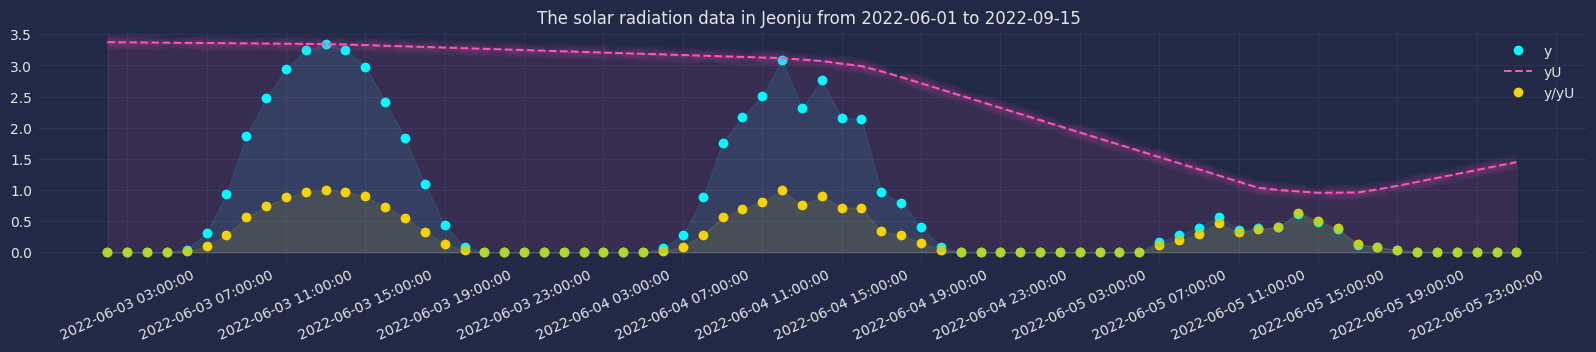

In [2]:
# read dataframe 
df = pd.read_csv('data_eng_230710.csv')

# make y, y_upper, y_period, time, regions 
y = df.loc[:,'Bukchoncheon':'Gyeongju-si'].to_numpy()
yU = df.loc[:,'Bukchoncheon_Upper':'Gyeongju-si_Upper'].to_numpy()
yP = np.divide(y, yU+1e-10)
t = df.loc[:,'date']
regions = list(df.loc[:,'Bukchoncheon':'Gyeongju-si'].columns)

# plot rawdata 
start = 50 
end = 50+24*3
city = 19 # 광주 
with plt.style.context('cyberpunk'):
    plt.rcParams['figure.figsize'] = [20, 3]  # [가로 크기, 세로 크기]
    plt.plot(t[start:end],y[start:end,city],'o',label='y')
    plt.plot(t[start:end],yU[start:end,city],'--',label='yU')
    plt.plot(t[start:end],yP[start:end,city],'o',label='y/yU')
    tick_interval = 4
    plt.xticks(range(1, len(t) + 1, tick_interval),rotation=25)        
    plt.legend()
    plt.title("The solar radiation data in {} from {} to {} ".format(regions[city],t.to_list()[0][:10],t.to_list()[-1][:10]))
    mplcyberpunk.add_glow_effects()    # 음영

# lag=4

## lag=4, filter=4, epoch=50

In [3]:
# global params
TRAIN_RATIO = 0.8
T,N = len(t),len(regions) 
LEN_TEST = int(np.floor(T*(1-TRAIN_RATIO)))
LEN_TR = T - LEN_TEST

# hyper params
LAGS = 4
FILTERS = 4
EPOCH = 50

In [4]:
# 방법1
yhat = rgcn(y,train_ratio = TRAIN_RATIO, lags=LAGS, filters=FILTERS, epoch=EPOCH)
yhat[yhat < 0]= 0 

# 방법2 
yUhat = rgcn(yU,train_ratio = TRAIN_RATIO, lags=LAGS,filters=FILTERS, epoch=EPOCH)

yPhat = rgcn(yP,train_ratio = TRAIN_RATIO, lags=LAGS,filters=FILTERS, epoch=EPOCH)
yPhat[yPhat < 0] =0 


classic = ((y - yhat)[LEN_TR:, :] ** 2)
proposed = ((y - yUhat*yPhat)[LEN_TR:, :] ** 2)

# print mse
print("""
total_mse(classic): {:.4f}
total_mse(proposed): {:.4f}
""".format(classic.mean(), proposed.mean()))

50/50
total_mse(classic): 0.8791
total_mse(proposed): 1.1683



In [5]:
GConvLSTM_yhat = yhat
GConvLSTM_yUhat = yUhat
GConvLSTM_yPhat = yPhat

GConvLSTM_classic = ((y - yhat)[LEN_TR:, :] ** 2)
GConvLSTM_proposed = ((y - yUhat*yPhat)[LEN_TR:, :] ** 2)

`-` classic

In [6]:
with plt.style.context('cyberpunk'): 
    plt.rcParams['figure.figsize'] = [20, 3]  # [가로 크기, 세로 크기]
    plt.plot(y[50:150,0],'o-',label='real')
    plt.plot(GConvLSTM_yhat[50:150,0],'o--',label='predited')
    plt.legend()
    mplcyberpunk.add_glow_effects()

`-` yP vs. yPhat

In [7]:
with plt.style.context('cyberpunk'): 
    plt.rcParams['figure.figsize'] = [20, 3]  # [가로 크기, 세로 크기]
    plt.plot(yP[50:150,city],'o-',label='real')
    plt.plot(GConvLSTM_yPhat[50:150,city],'o--',label='predited')
    plt.legend()
    mplcyberpunk.add_glow_effects()   

`-` yU vs yUhat

In [8]:
with plt.style.context('cyberpunk'): 
    plt.rcParams['figure.figsize'] = [20, 3]  # [가로 크기, 세로 크기]
    plt.plot(yU[:,25],label='real')
    plt.plot(GConvLSTM_yUhat[:,25],label='predited')
    plt.legend()
    mplcyberpunk.add_glow_effects()    

`-` y vs (yUhat\*yPhat)

In [9]:
with plt.style.context('cyberpunk'): 
    plt.rcParams['figure.figsize'] = [20, 3]  # [가로 크기, 세로 크기]
    plt.plot(y[50:150,0],'o-',label='real')
    plt.plot((GConvLSTM_yUhat*GConvLSTM_yPhat)[50:150,0],'o--',label='predited')
    plt.legend()
    mplcyberpunk.add_glow_effects()    

`-` 지역별 분석

In [ ]:
with plt.style.context('cyberpunk'):
    plt.rcParams['figure.figsize'] = [20, 3]  # [가로 크기, 세로 크기]
    plt.plot(regions,GConvLSTM_classic.mean(axis=0)-GConvLSTM_proposed.mean(axis=0),'--o');
    plt.xticks(regions, rotation=55, ha='right');    
    mplcyberpunk.add_glow_effects()    

## lag=4, filter=8, epoch=50

In [ ]:
# hyper params
LAGS = 4
FILTERS = 8
EPOCH = 50

In [ ]:
# 방법1
yhat = rgcn(y,train_ratio = TRAIN_RATIO, lags=LAGS, filters=FILTERS, epoch=EPOCH)
yhat[yhat < 0]= 0 

# 방법2 
yUhat = rgcn(yU,train_ratio = TRAIN_RATIO, lags=LAGS,filters=FILTERS, epoch=EPOCH)

yPhat = rgcn(yP,train_ratio = TRAIN_RATIO, lags=LAGS,filters=FILTERS, epoch=EPOCH)
yPhat[yPhat < 0] =0 


classic = ((y - yhat)[LEN_TR:, :] ** 2)
proposed = ((y - yUhat*yPhat)[LEN_TR:, :] ** 2)

# print mse
print("""
total_mse(classic): {:.4f}
total_mse(proposed): {:.4f}
""".format(classic.mean(), proposed.mean()))

In [ ]:
GConvLSTM_yhat = yhat
GConvLSTM_yUhat = yUhat
GConvLSTM_yPhat = yPhat

GConvLSTM_classic = ((y - yhat)[LEN_TR:, :] ** 2)
GConvLSTM_proposed = ((y - yUhat*yPhat)[LEN_TR:, :] ** 2)

`-` classic

In [ ]:
with plt.style.context('cyberpunk'): 
    plt.rcParams['figure.figsize'] = [20, 3]  # [가로 크기, 세로 크기]
    plt.plot(y[50:150,0],'o-',label='real')
    plt.plot(GConvLSTM_yhat[50:150,0],'o--',label='predited')
    plt.legend()
    mplcyberpunk.add_glow_effects()

`-` yP vs. yPhat

In [ ]:
with plt.style.context('cyberpunk'): 
    plt.rcParams['figure.figsize'] = [20, 3]  # [가로 크기, 세로 크기]
    plt.plot(yP[50:150,city],'o-',label='real')
    plt.plot(GConvLSTM_yPhat[50:150,city],'o--',label='predited')
    plt.legend()
    mplcyberpunk.add_glow_effects()   

`-` yU vs yUhat

In [ ]:
with plt.style.context('cyberpunk'): 
    plt.rcParams['figure.figsize'] = [20, 3]  # [가로 크기, 세로 크기]
    plt.plot(yU[:,25],label='real')
    plt.plot(GConvLSTM_yUhat[:,25],label='predited')
    plt.legend()
    mplcyberpunk.add_glow_effects()    

`-` y vs (yUhat\*yPhat)

In [ ]:
with plt.style.context('cyberpunk'): 
    plt.rcParams['figure.figsize'] = [20, 3]  # [가로 크기, 세로 크기]
    plt.plot(y[50:150,0],'o-',label='real')
    plt.plot((GConvLSTM_yUhat*GConvLSTM_yPhat)[50:150,0],'o--',label='predited')
    plt.legend()
    mplcyberpunk.add_glow_effects()    

`-` 지역별 분석

In [ ]:
with plt.style.context('cyberpunk'):
    plt.rcParams['figure.figsize'] = [20, 3]  # [가로 크기, 세로 크기]
    plt.plot(regions,GConvLSTM_classic.mean(axis=0)-GConvLSTM_proposed.mean(axis=0),'--o');
    plt.xticks(regions, rotation=55, ha='right');    
    mplcyberpunk.add_glow_effects()    

## lag=4, filter=16, epoch=50

In [ ]:
# hyper params
LAGS = 4
FILTERS = 16
EPOCH = 50

In [13]:
# 방법1
yhat = rgcn(y,train_ratio = TRAIN_RATIO, lags=LAGS, filters=FILTERS, epoch=EPOCH)
yhat[yhat < 0]= 0 

# 방법2 
yUhat = rgcn(yU,train_ratio = TRAIN_RATIO, lags=LAGS,filters=FILTERS, epoch=EPOCH)

yPhat = rgcn(yP,train_ratio = TRAIN_RATIO, lags=LAGS,filters=FILTERS, epoch=EPOCH)
yPhat[yPhat < 0] =0 


classic = ((y - yhat)[LEN_TR:, :] ** 2)
proposed = ((y - yUhat*yPhat)[LEN_TR:, :] ** 2)

# print mse
print("""
total_mse(classic): {:.4f}
total_mse(proposed): {:.4f}
""".format(classic.mean(), proposed.mean()))

50/50
total_mse(classic): 0.0574
total_mse(proposed): 0.0664


In [14]:
GConvLSTM_yhat = yhat
GConvLSTM_yUhat = yUhat
GConvLSTM_yPhat = yPhat

GConvLSTM_classic = ((y - yhat)[LEN_TR:, :] ** 2)
GConvLSTM_proposed = ((y - yUhat*yPhat)[LEN_TR:, :] ** 2)

`-` classic

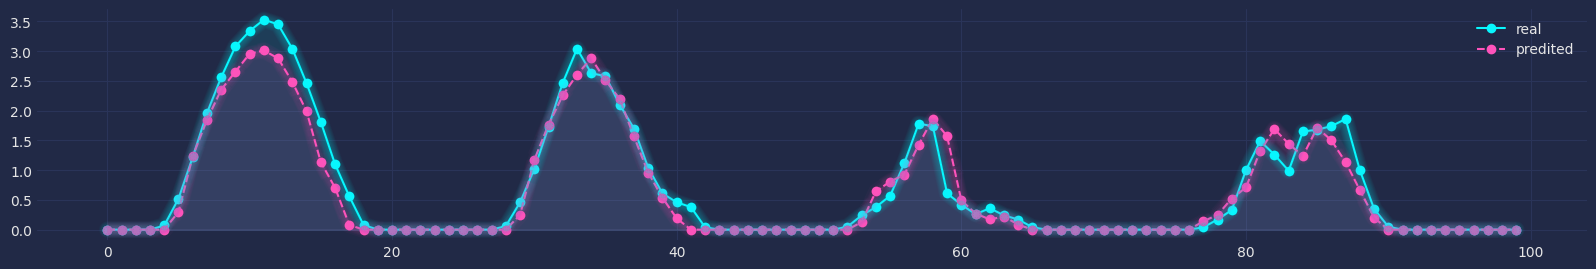

In [15]:
with plt.style.context('cyberpunk'): 
    plt.rcParams['figure.figsize'] = [20, 3]  # [가로 크기, 세로 크기]
    plt.plot(y[50:150,0],'o-',label='real')
    plt.plot(GConvLSTM_yhat[50:150,0],'o--',label='predited')
    plt.legend()
    mplcyberpunk.add_glow_effects()

`-` yP vs. yPhat

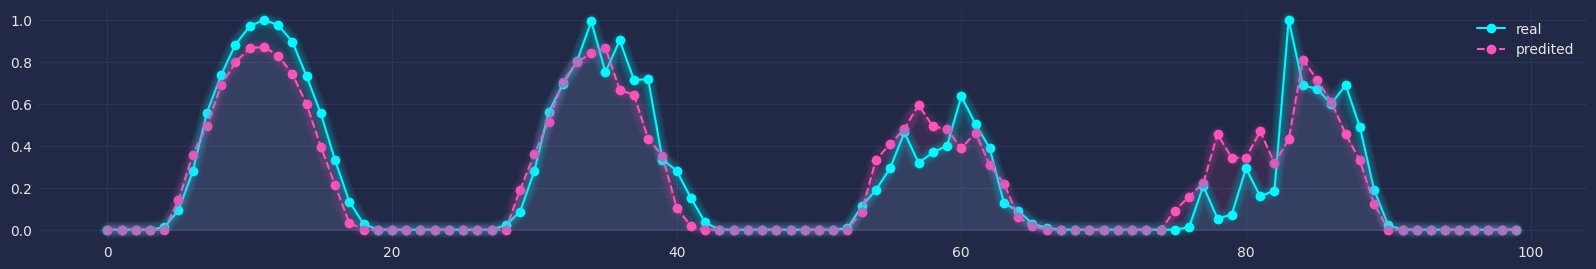

In [16]:
with plt.style.context('cyberpunk'): 
    plt.rcParams['figure.figsize'] = [20, 3]  # [가로 크기, 세로 크기]
    plt.plot(yP[50:150,city],'o-',label='real')
    plt.plot(GConvLSTM_yPhat[50:150,city],'o--',label='predited')
    plt.legend()
    mplcyberpunk.add_glow_effects()   

`-` yU vs yUhat

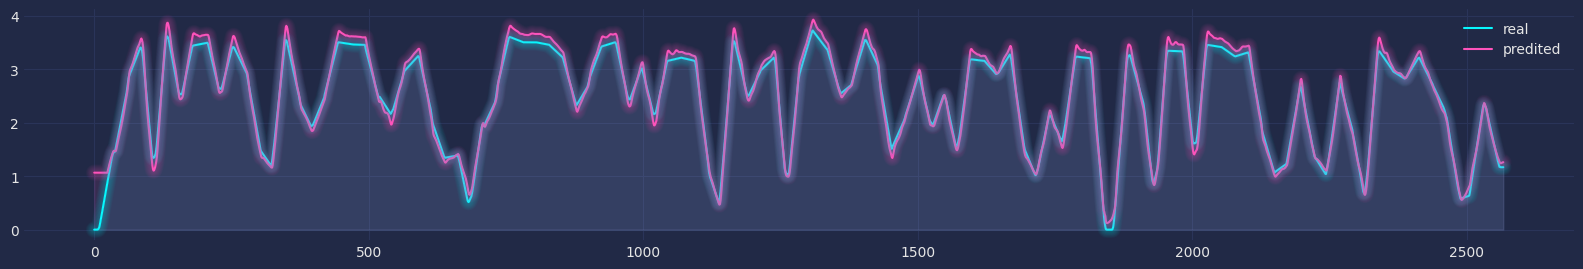

In [17]:
with plt.style.context('cyberpunk'): 
    plt.rcParams['figure.figsize'] = [20, 3]  # [가로 크기, 세로 크기]
    plt.plot(yU[:,25],label='real')
    plt.plot(GConvLSTM_yUhat[:,25],label='predited')
    plt.legend()
    mplcyberpunk.add_glow_effects()    

`-` y vs (yUhat\*yPhat)

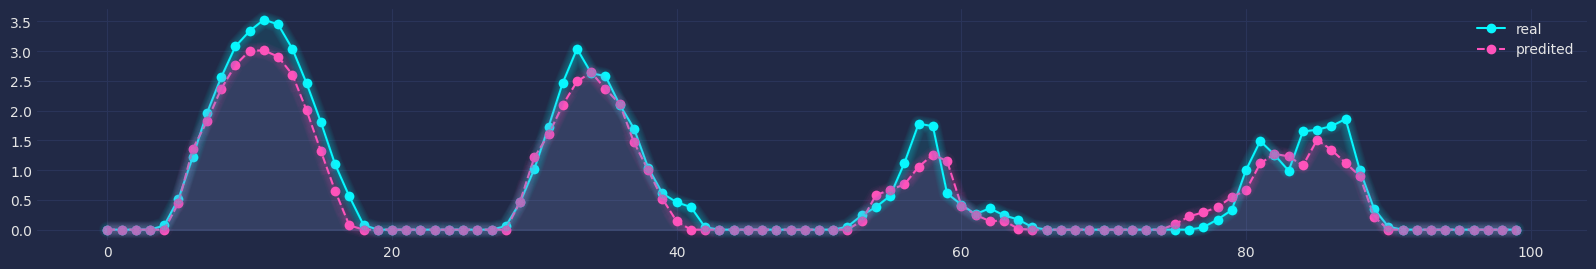

In [18]:
with plt.style.context('cyberpunk'): 
    plt.rcParams['figure.figsize'] = [20, 3]  # [가로 크기, 세로 크기]
    plt.plot(y[50:150,0],'o-',label='real')
    plt.plot((GConvLSTM_yUhat*GConvLSTM_yPhat)[50:150,0],'o--',label='predited')
    plt.legend()
    mplcyberpunk.add_glow_effects()    

`-` 지역별 분석

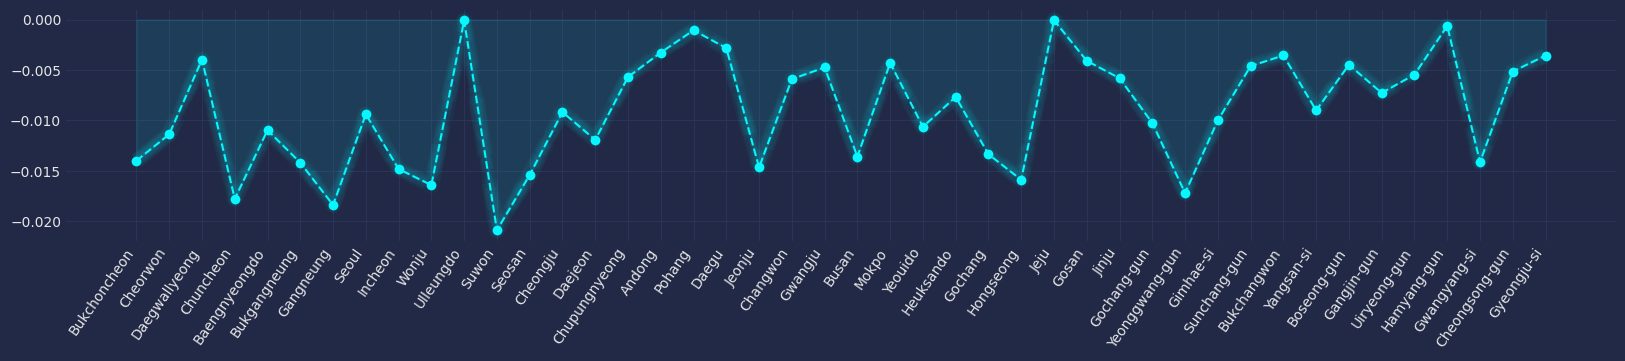

In [19]:
with plt.style.context('cyberpunk'):
    plt.rcParams['figure.figsize'] = [20, 3]  # [가로 크기, 세로 크기]
    plt.plot(regions,GConvLSTM_classic.mean(axis=0)-GConvLSTM_proposed.mean(axis=0),'--o');
    plt.xticks(regions, rotation=55, ha='right');    
    mplcyberpunk.add_glow_effects()    

In [28]:
# hyper params
LAGS = 24
FILTERS = 32
EPOCH = 50

In [29]:
# 방법1
yhat = rgcn(y,train_ratio = TRAIN_RATIO, lags=LAGS, filters=FILTERS, epoch=EPOCH)
yhat[yhat < 0]= 0 

# 방법2 
yUhat = rgcn(yU,train_ratio = TRAIN_RATIO, lags=LAGS,filters=FILTERS, epoch=EPOCH)

yPhat = rgcn(yP,train_ratio = TRAIN_RATIO, lags=LAGS,filters=FILTERS, epoch=EPOCH)
yPhat[yPhat < 0] =0 


classic = ((y - yhat)[LEN_TR:, :] ** 2)
proposed = ((y - yUhat*yPhat)[LEN_TR:, :] ** 2)

# print mse
print("""
total_mse(classic): {:.4f}
total_mse(proposed): {:.4f}
""".format(classic.mean(), proposed.mean()))

50/50
total_mse(classic): 0.0572
total_mse(proposed): 0.0896


In [30]:
GConvLSTM_yhat = yhat
GConvLSTM_yUhat = yUhat
GConvLSTM_yPhat = yPhat

GConvLSTM_classic = ((y - yhat)[LEN_TR:, :] ** 2)
GConvLSTM_proposed = ((y - yUhat*yPhat)[LEN_TR:, :] ** 2)

`-` classic

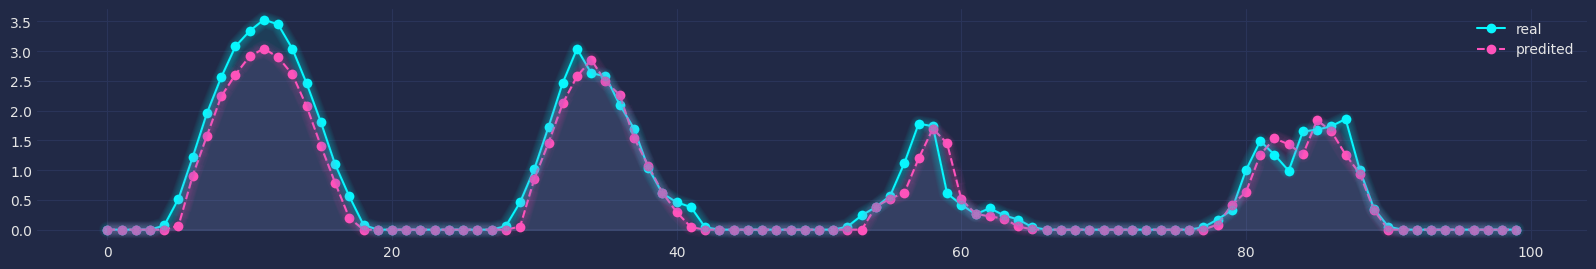

In [31]:
with plt.style.context('cyberpunk'): 
    plt.rcParams['figure.figsize'] = [20, 3]  # [가로 크기, 세로 크기]
    plt.plot(y[50:150,0],'o-',label='real')
    plt.plot(GConvLSTM_yhat[50:150,0],'o--',label='predited')
    plt.legend()
    mplcyberpunk.add_glow_effects()

`-` yP vs. yPhat

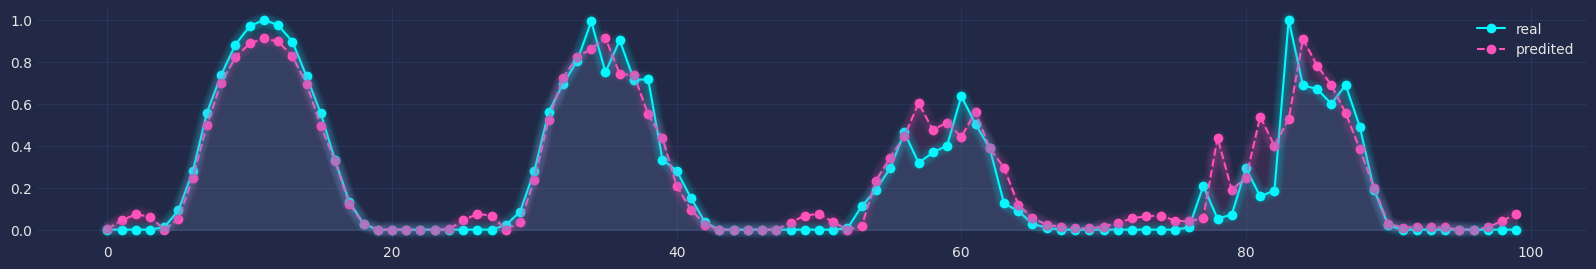

In [32]:
with plt.style.context('cyberpunk'): 
    plt.rcParams['figure.figsize'] = [20, 3]  # [가로 크기, 세로 크기]
    plt.plot(yP[50:150,city],'o-',label='real')
    plt.plot(GConvLSTM_yPhat[50:150,city],'o--',label='predited')
    plt.legend()
    mplcyberpunk.add_glow_effects()   

`-` yU vs yUhat

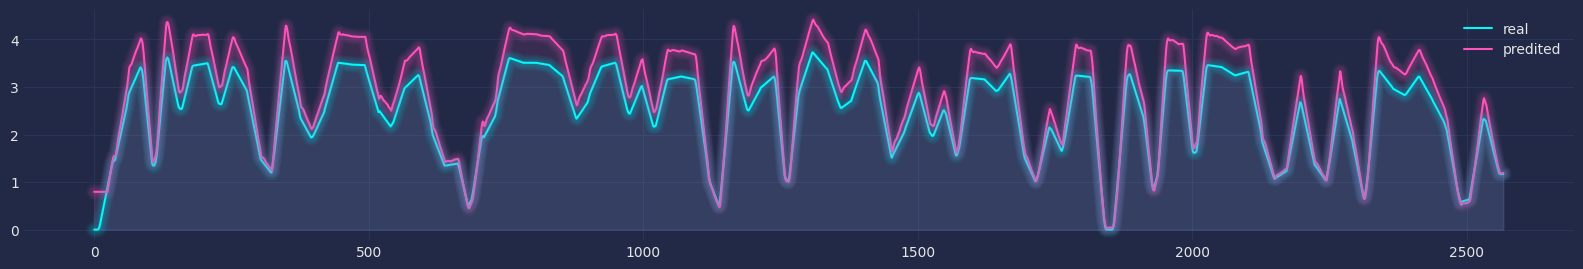

In [33]:
with plt.style.context('cyberpunk'): 
    plt.rcParams['figure.figsize'] = [20, 3]  # [가로 크기, 세로 크기]
    plt.plot(yU[:,25],label='real')
    plt.plot(GConvLSTM_yUhat[:,25],label='predited')
    plt.legend()
    mplcyberpunk.add_glow_effects()    

`-` y vs (yUhat\*yPhat)

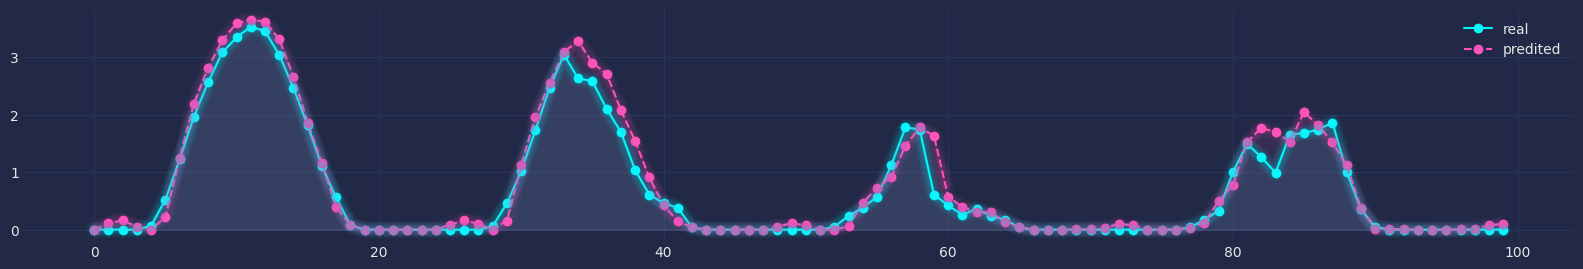

In [34]:
with plt.style.context('cyberpunk'): 
    plt.rcParams['figure.figsize'] = [20, 3]  # [가로 크기, 세로 크기]
    plt.plot(y[50:150,0],'o-',label='real')
    plt.plot((GConvLSTM_yUhat*GConvLSTM_yPhat)[50:150,0],'o--',label='predited')
    plt.legend()
    mplcyberpunk.add_glow_effects()    

`-` 지역별 분석

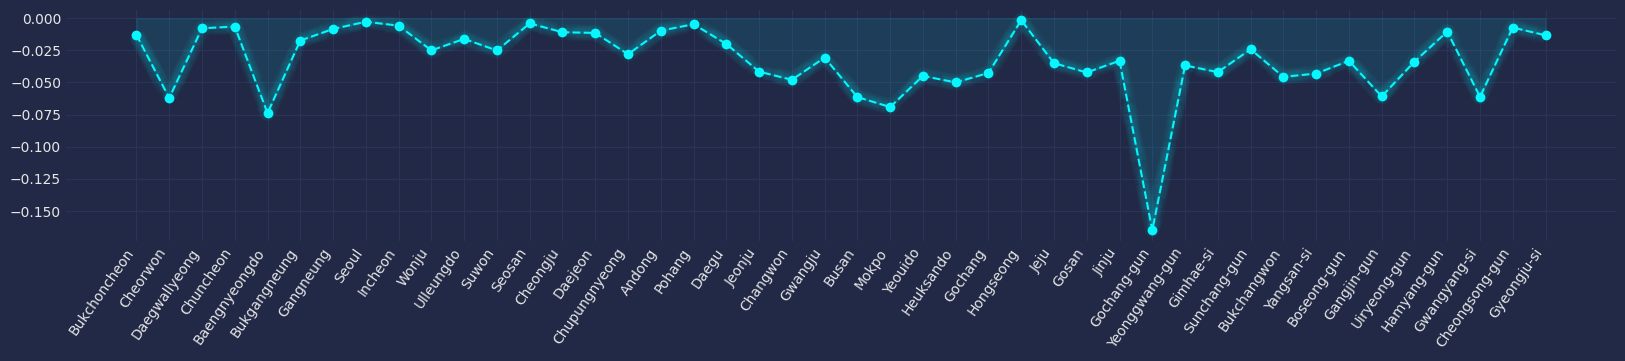

In [35]:
with plt.style.context('cyberpunk'):
    plt.rcParams['figure.figsize'] = [20, 3]  # [가로 크기, 세로 크기]
    plt.plot(regions,GConvLSTM_classic.mean(axis=0)-GConvLSTM_proposed.mean(axis=0),'--o');
    plt.xticks(regions, rotation=55, ha='right');    
    mplcyberpunk.add_glow_effects()    

In [174]:
from torch_geometric_temporal.nn.recurrent import GCLSTM

    GCLSTM(
        in_channels: int,
        out_channels: int,
        K: int,
        normalization: str = 'sym',
        bias: bool = True,

In [177]:
class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features, filters):
        super(RecurrentGCN, self).__init__()
        self.recurrent = GCLSTM(node_features, filters, 2)
        self.linear = torch.nn.Linear(filters, 1)

    def forward(self, x, edge_index, edge_weight, h, c):
        h_0, c_0 = self.recurrent(x, edge_index, edge_weight, h, c)
        h = F.relu(h_0)
        h = self.linear(h)
        return h, h_0, c_0

In [193]:
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

In [194]:
class RGCN_Learner:
    def __init__(self,train_dataset,dataset_name = None):
        self.train_dataset = train_dataset
        self.lags = torch.tensor(train_dataset.features).shape[-1]
        self.dataset_name = str(train_dataset) if dataset_name is None else dataset_name
        self.method = 'RecurrentGCN'
    def learn(self,filters=32,epoch=50):
        self.model = RecurrentGCN(node_features=self.lags, filters=filters).to(device)
        self.optimizer = torch.optim.Adam(self.model.parameters())
        self.model.train()
        for e in range(epoch):
            # self.h, self.c = None, None
            for snapshot in self.train_dataset:
                self.h, self.c = None, None
                snapshot = snapshot.to(device)
                yt_hat, self.h, self.c = self.model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, self.h, self.c)
                # cost = cost + torch.mean((yt_hat.reshape(-1)-snapshot.y.reshape(-1))**2)
                cost = torch.mean((yt_hat.reshape(-1)-snapshot.y.reshape(-1))**2)
                cost.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()
            print('{}/{}'.format(e+1,epoch),end='\r')
        # recording HP
        self.nof_filters = filters
        # self.epochs = epoch+1
        self.epochs = epoch
    def __call__(self,dataset):
        X = torch.tensor(dataset.features).float()
        y = torch.tensor(dataset.targets).float()
        yhat = torch.stack([self.model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, self.h, self.c)[0] for snapshot in dataset]).detach().squeeze().float()
        return {'X':X, 'y':y, 'yhat':yhat} 

# learn 
def rgcn(FX,train_ratio,lags,filters,epoch):
    dct = makedict(FX=FX.tolist())
    loader = Loader(dct)
    dataset = loader.get_dataset(lags=lags)
    dataset_tr, dataset_test = eptstgcn.utils.temporal_signal_split(dataset, train_ratio = train_ratio)
    lrnr = RGCN_Learner(dataset_tr, dataset_name = 'org & arbitrary')
    lrnr.learn(filters=filters, epoch=epoch)
    yhat = np.array(lrnr(dataset)['yhat'])
    yhat = np.concatenate([np.array([list(yhat[0])]*lags),yhat],axis=0)
    return yhat

In [195]:
# hyper params
LAGS = 12
FILTERS = 4
EPOCH = 50

In [197]:
# 방법1
yhat = rgcn(y,train_ratio = TRAIN_RATIO, lags=LAGS,filters=FILTERS,epoch=EPOCH)
yhat[yhat < 0]= 0 

# 방법2 
yUhat = rgcn(yU,train_ratio = TRAIN_RATIO, lags=LAGS,filters=FILTERS,epoch=EPOCH)

yPhat = rgcn(yP,train_ratio = TRAIN_RATIO, lags=LAGS,filters=FILTERS,epoch=EPOCH)
yPhat[yPhat < 0] =0 


classic = ((y - yhat)[LEN_TR:, :] ** 2)
proposed = ((y - yUhat*yPhat)[LEN_TR:, :] ** 2)

# print mse
print("""
total_mse(classic): {:.4f}
total_mse(proposed): {:.4f}
""".format(classic.mean(), proposed.mean()))

30/30
total_mse(classic): 0.2584
total_mse(proposed): 0.3364


In [202]:
GCLSTM_yhat = yhat
GCLSTM_yUhat = yUhat
GCLSTM_yPhat = yPhat

GCLSTM_classic = ((y - yhat)[LEN_TR:, :] ** 2)
GCLSTM_proposed = ((y - yUhat*yPhat)[LEN_TR:, :] ** 2)

`-` classic

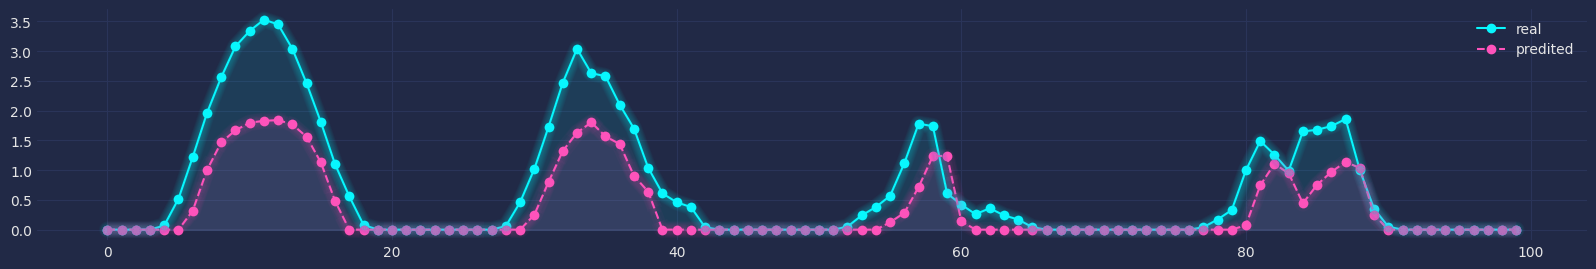

In [198]:
with plt.style.context('cyberpunk'): 
    plt.rcParams['figure.figsize'] = [20, 3]  # [가로 크기, 세로 크기]
    plt.plot(y[50:150,0],'o-',label='real')
    plt.plot(GCLSTM_yhat[50:150,0],'o--',label='predited')
    plt.legend()
    mplcyberpunk.add_glow_effects()

`-` yP vs yPhat

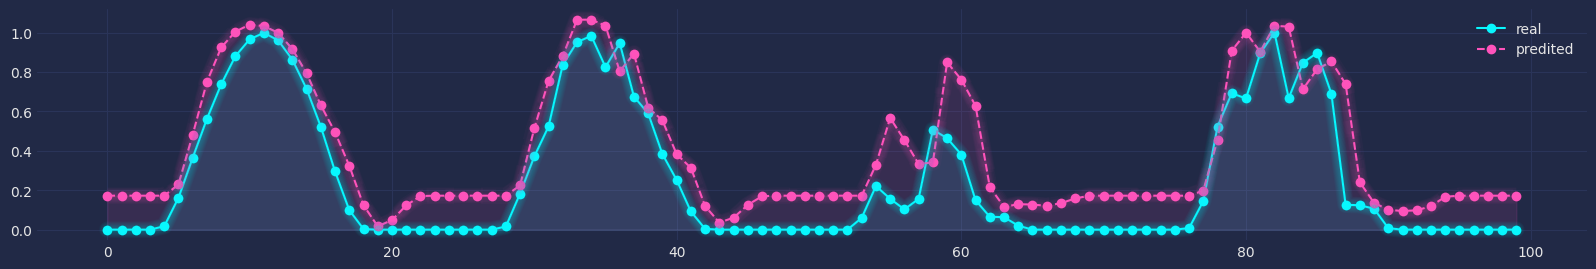

In [205]:
with plt.style.context('cyberpunk'): 
    plt.rcParams['figure.figsize'] = [20, 3]  # [가로 크기, 세로 크기]
    plt.plot(yP[50:150,city],'o-',label='real')
    plt.plot(GCLSTM_yPhat[50:150,city],'o--',label='predited')
    plt.legend()
    mplcyberpunk.add_glow_effects()    

`-` y vs (yUhat\*yPhat) \>\> proposed

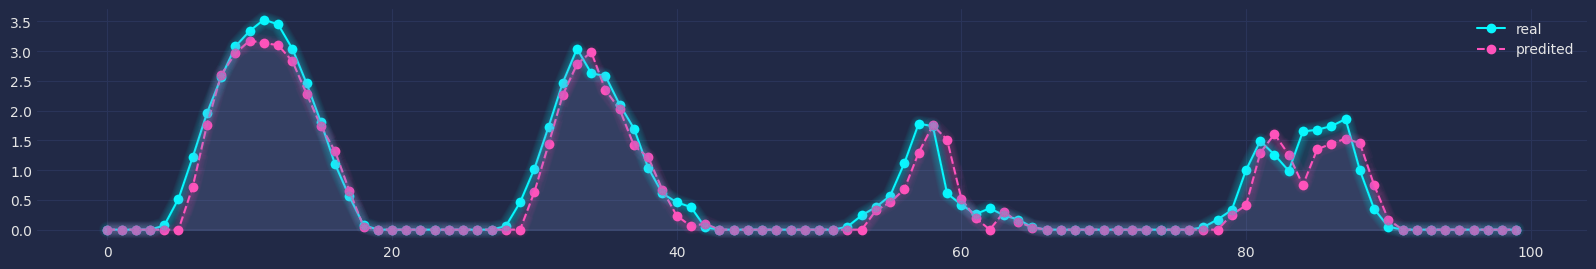

In [206]:
with plt.style.context('cyberpunk'): 
    plt.rcParams['figure.figsize'] = [20, 3]  # [가로 크기, 세로 크기]
    plt.plot(y[50:150,0],'o-',label='real')
    plt.plot((GCLSTM_yUhat*GCLSTM_yPhat)[50:150,0],'o--',label='predited')
    plt.legend()
    mplcyberpunk.add_glow_effects()    

`-` 지역별분석

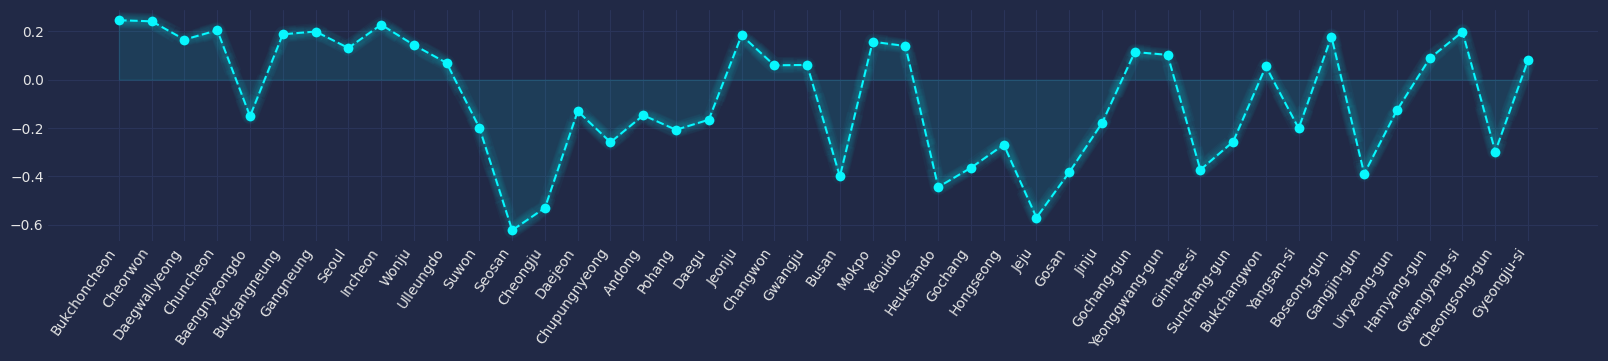

In [207]:
with plt.style.context('cyberpunk'):
    plt.rcParams['figure.figsize'] = [20, 3]  # [가로 크기, 세로 크기]
    plt.plot(regions,GCLSTM_classic.mean(axis=0)-GCLSTM_proposed.mean(axis=0),'--o');
    plt.xticks(regions, rotation=55, ha='right');    
    mplcyberpunk.add_glow_effects()    

In [208]:
from torch_geometric_temporal.nn.recurrent import LRGCN

In [209]:
class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features, filters):
        super(RecurrentGCN, self).__init__()
        self.recurrent = LRGCN(node_features, filters, 1, 1)
        self.linear = torch.nn.Linear(filters, 1)

    def forward(self, x, edge_index, edge_weight, h_0, c_0):
        h_0, c_0 = self.recurrent(x, edge_index, edge_weight, h_0, c_0)
        h = F.relu(h_0)
        h = self.linear(h)
        return h, h_0, c_0

In [210]:
class RGCN_Learner:
    def __init__(self,train_dataset,dataset_name = None):
        self.train_dataset = train_dataset
        self.lags = torch.tensor(train_dataset.features).shape[-1]
        self.dataset_name = str(train_dataset) if dataset_name is None else dataset_name
        self.method = 'RecurrentGCN'
    def learn(self,filters=32,epoch=50):
        self.model = RecurrentGCN(node_features=self.lags, filters=filters).to(device)
        self.optimizer = torch.optim.Adam(self.model.parameters())
        self.model.train()
        for e in range(epoch):
            for snapshot in self.train_dataset:
                self.h, self.c = None, None
                snapshot = snapshot.to(device)
                yt_hat, self.h, self.c = self.model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, self.h, self.c)
                cost = torch.mean((yt_hat.reshape(-1)-snapshot.y.reshape(-1))**2)
                cost.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()
            print('{}/{}'.format(e+1,epoch),end='\r')
        # recording HP
        self.nof_filters = filters
        # self.epochs = epoch+1
        self.epochs = epoch
    def __call__(self,dataset):
        X = torch.tensor(dataset.features).float()
        y = torch.tensor(dataset.targets).float()
        yhat = torch.stack([self.model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, self.h, self.c)[0] for snapshot in dataset]).detach().squeeze().float()
        return {'X':X, 'y':y, 'yhat':yhat} 

# learn 
def rgcn(FX,train_ratio,lags,filters,epoch):
    dct = makedict(FX=FX.tolist())
    loader = Loader(dct)
    dataset = loader.get_dataset(lags=lags)
    dataset_tr, dataset_test = eptstgcn.utils.temporal_signal_split(dataset, train_ratio = train_ratio)
    lrnr = RGCN_Learner(dataset_tr, dataset_name = 'org & arbitrary')
    lrnr.learn(filters=filters, epoch=epoch)
    yhat = np.array(lrnr(dataset)['yhat'])
    yhat = np.concatenate([np.array([list(yhat[0])]*lags),yhat],axis=0)
    return yhat

In [211]:
# hyper params
LAGS = 4
FILTERS = 4
EPOCH = 30

In [212]:
# 방법1
yhat = rgcn(y,train_ratio = TRAIN_RATIO, lags=LAGS,filters=FILTERS,epoch=EPOCH)
yhat[yhat < 0]= 0 

# 방법2 
yUhat = rgcn(yU,train_ratio = TRAIN_RATIO, lags=LAGS,filters=FILTERS,epoch=EPOCH)

yPhat = rgcn(yP,train_ratio = TRAIN_RATIO, lags=LAGS,filters=FILTERS,epoch=EPOCH)
yPhat[yPhat < 0] =0 


classic = ((y - yhat)[LEN_TR:, :] ** 2)
proposed = ((y - yUhat*yPhat)[LEN_TR:, :] ** 2)

# print mse
print("""
total_mse(classic): {:.4f}
total_mse(proposed): {:.4f}
""".format(classic.mean(), proposed.mean()))

30/30
total_mse(classic): 0.4837
total_mse(proposed): 0.7375


In [213]:
LRGCN_yhat = yhat
LRGCN_yUhat = yUhat
LRGCN_yPhat = yPhat

LRGCN_classic = ((y - yhat)[LEN_TR:, :] ** 2)
LRGCN_proposed = ((y - yUhat*yPhat)[LEN_TR:, :] ** 2)

`-` classic

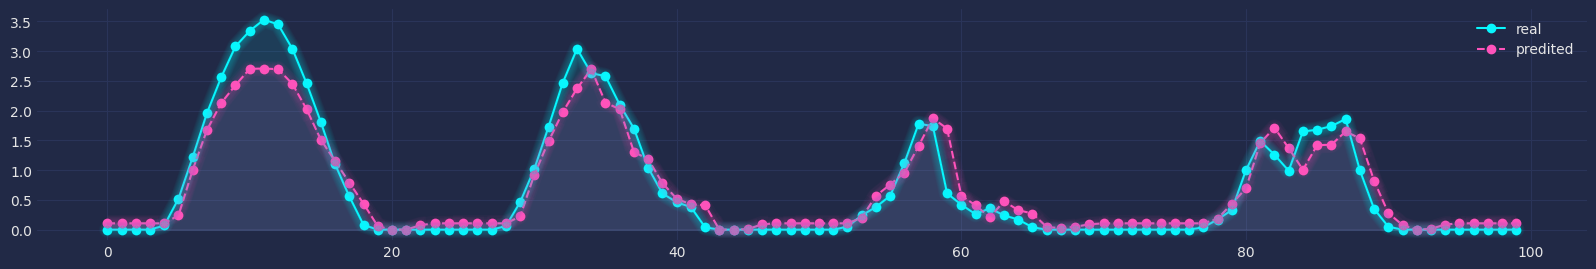

In [214]:
with plt.style.context('cyberpunk'): 
    plt.rcParams['figure.figsize'] = [20, 3]  # [가로 크기, 세로 크기]
    plt.plot(y[50:150,0],'o-',label='real')
    plt.plot(LRGCN_yhat[50:150,0],'o--',label='predited')
    plt.legend()
    mplcyberpunk.add_glow_effects()

`-` yP vs yPhat

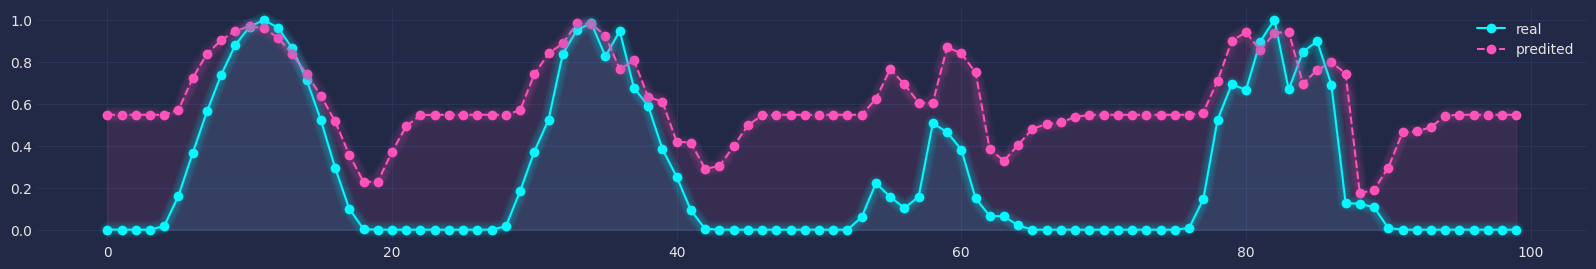

In [215]:
with plt.style.context('cyberpunk'): 
    plt.rcParams['figure.figsize'] = [20, 3]  # [가로 크기, 세로 크기]
    plt.plot(yP[50:150,city],'o-',label='real')
    plt.plot(LRGCN_yPhat[50:150,city],'o--',label='predited')
    plt.legend()
    mplcyberpunk.add_glow_effects()    

`-` y vs (yUhat\*yPhat) \>\> proposed

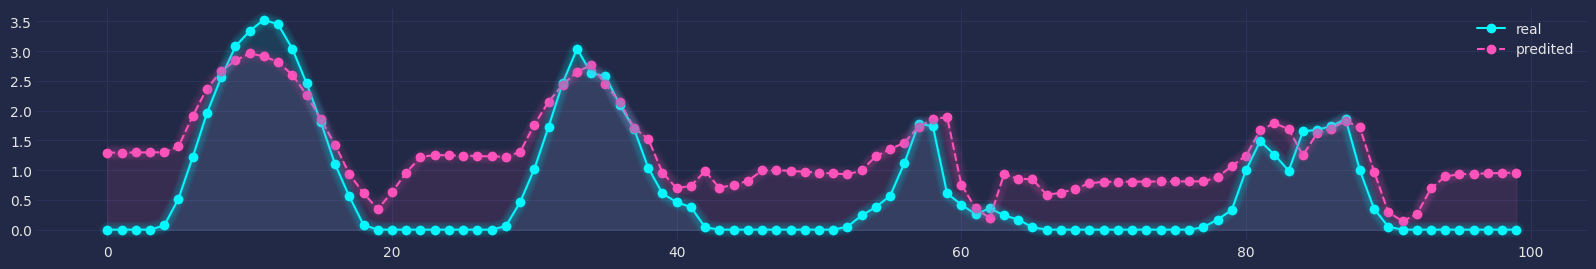

In [216]:
with plt.style.context('cyberpunk'): 
    plt.rcParams['figure.figsize'] = [20, 3]  # [가로 크기, 세로 크기]
    plt.plot(y[50:150,0],'o-',label='real')
    plt.plot((LRGCN_yUhat*LRGCN_yPhat)[50:150,0],'o--',label='predited')
    plt.legend()
    mplcyberpunk.add_glow_effects()    

`-` 지역별분석

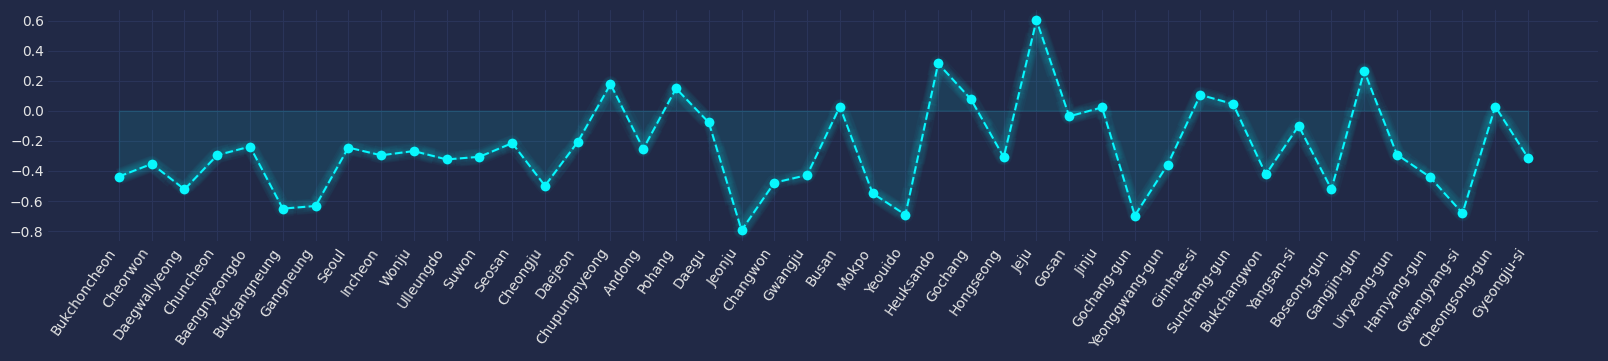

In [217]:
with plt.style.context('cyberpunk'):
    plt.rcParams['figure.figsize'] = [20, 3]  # [가로 크기, 세로 크기]
    plt.plot(regions,LRGCN_classic.mean(axis=0)-LRGCN_proposed.mean(axis=0),'--o');
    plt.xticks(regions, rotation=55, ha='right');    
    mplcyberpunk.add_glow_effects()    

`-` classic

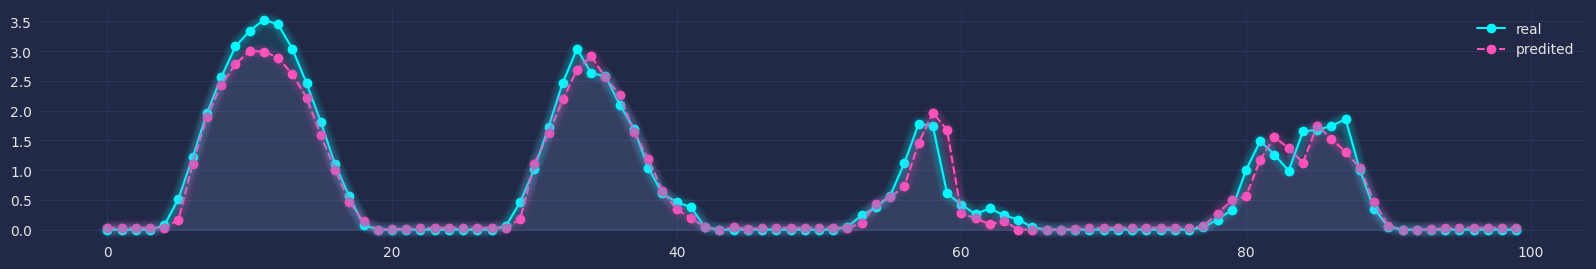

In [240]:
with plt.style.context('cyberpunk'): 
    plt.rcParams['figure.figsize'] = [20, 3]  # [가로 크기, 세로 크기]
    plt.plot(y[50:150,0],'o-',label='real')
    plt.plot(DCRNN_yhat[50:150,0],'o--',label='predited')
    plt.legend()
    mplcyberpunk.add_glow_effects()

`-` yP vs yPhat

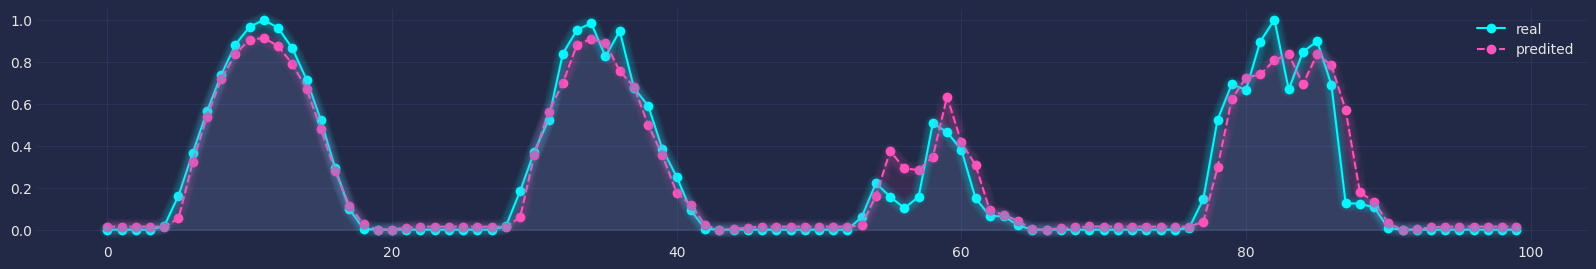

In [241]:
with plt.style.context('cyberpunk'): 
    plt.rcParams['figure.figsize'] = [20, 3]  # [가로 크기, 세로 크기]
    plt.plot(yP[50:150,city],'o-',label='real')
    plt.plot(DCRNN_yPhat[50:150,city],'o--',label='predited')
    plt.legend()
    mplcyberpunk.add_glow_effects()    

`-` y vs (yUhat\*yPhat) \>\> proposed

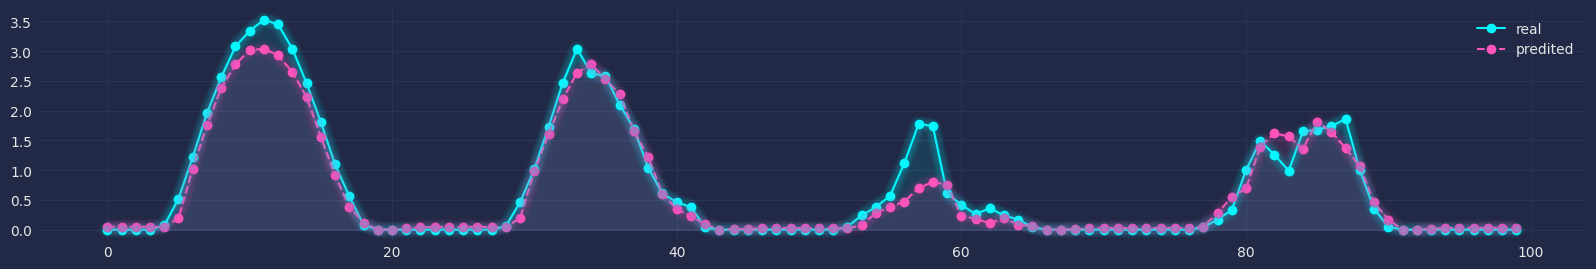

In [242]:
with plt.style.context('cyberpunk'): 
    plt.rcParams['figure.figsize'] = [20, 3]  # [가로 크기, 세로 크기]
    plt.plot(y[50:150,0],'o-',label='real')
    plt.plot((DCRNN_yUhat*DCRNN_yPhat)[50:150,0],'o--',label='predited')
    plt.legend()
    mplcyberpunk.add_glow_effects()    

`-` 지역별분석

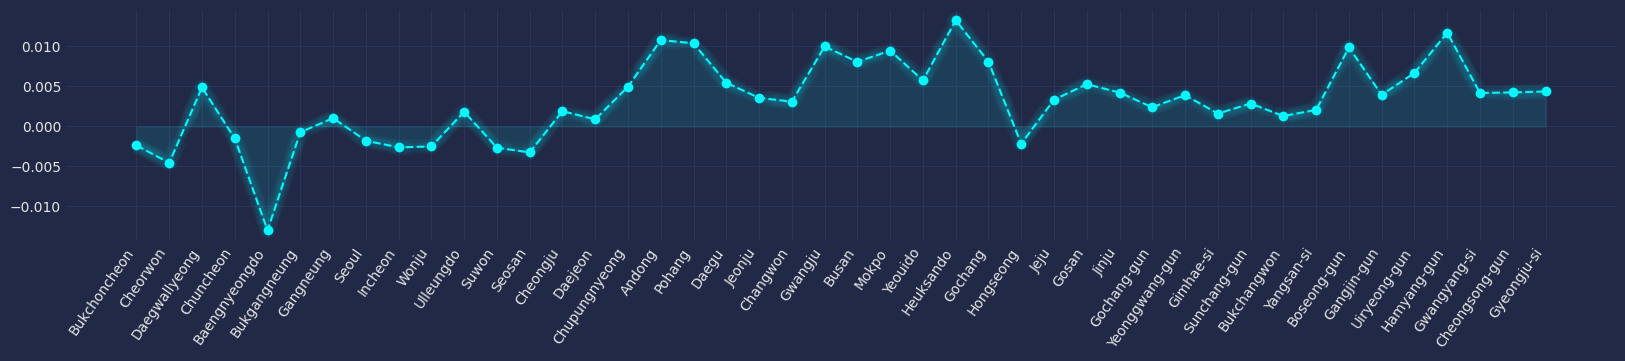

In [243]:
with plt.style.context('cyberpunk'):
    plt.rcParams['figure.figsize'] = [20, 3]  # [가로 크기, 세로 크기]
    plt.plot(regions,DCRNN_classic.mean(axis=0)-DCRNN_proposed.mean(axis=0),'--o');
    plt.xticks(regions, rotation=55, ha='right');    
    mplcyberpunk.add_glow_effects()    

-   ref:
    <https://pytorch-geometric-temporal.readthedocs.io/en/latest/modules/root.html>